In [22]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import os
import io
from PIL import Image
import seaborn as sns

In [23]:
train_data_dir = '4/train'
val_data_dir = '4/val'
test_data_dir = '4/test'

In [24]:
def get_data_loaders(batch_size=16, num_workers=2):
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
    trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
    valloader = torch.utils.data.DataLoader(valnset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    return trainloader, valloader, testloader

class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc_final(x)
        
        return x

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [25]:
def train(net, epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate((trainloader), 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    return running_loss/len(trainloader)

def test(testloader, model):
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data in (testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

    print('Accuracy of the network on the val/test images: %f %%' % (
                                    100 * correct / total))
    return 100*correct/total, total_loss/len(testloader)

In [26]:
num_epochs = 30
learning_rate = 0.001

trainloader, valloader, testloader = get_data_loaders()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [27]:
def train_and_get_stats(decay):
    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay)
    if torch.cuda.is_available():
        net = net.cuda()
    for epoch in range(num_epochs):
        _ = train(net, epoch, trainloader, optimizer, criterion)
    train_acc, train_loss = test(trainloader, net)
    val_acc, val_loss = test(valloader, net)
    test_acc, test_loss = test(testloader, net)
    return (train_acc, train_loss, val_acc, val_loss, test_acc, test_loss)

In [28]:
import pandas as pd

decay_list = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
test_acc_list = []
test_loss_list = []
for decay in decay_list:
    (train_acc, train_loss, val_acc, val_loss, test_acc, test_loss) = train_and_get_stats(decay)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

df = pd.DataFrame({'decay': decay_list, 'train_acc': train_acc_list, 'train_loss': train_loss_list, 'val_acc': val_acc_list, 'val_loss': val_loss_list, 'test_acc': test_acc_list, 'test_loss': test_loss_list})

epoch 1 training loss: 3.495
epoch 2 training loss: 3.475
epoch 3 training loss: 3.378
epoch 4 training loss: 3.225
epoch 5 training loss: 3.065
epoch 6 training loss: 2.963
epoch 7 training loss: 2.834
epoch 8 training loss: 2.744
epoch 9 training loss: 2.675
epoch 10 training loss: 2.596
epoch 11 training loss: 2.518
epoch 12 training loss: 2.434
epoch 13 training loss: 2.357
epoch 14 training loss: 2.278
epoch 29 training loss: 1.069
epoch 30 training loss: 0.976
Accuracy of the network on the val/test images: 74.689394 %
Accuracy of the network on the val/test images: 42.060606 %
Accuracy of the network on the val/test images: 44.636364 %
epoch 1 training loss: 3.496
epoch 2 training loss: 3.481
epoch 3 training loss: 3.373
epoch 4 training loss: 3.177
epoch 5 training loss: 3.084
epoch 6 training loss: 3.011
epoch 7 training loss: 2.954
epoch 8 training loss: 2.898
epoch 9 training loss: 2.790
epoch 10 training loss: 2.680
epoch 11 training loss: 2.589
epoch 12 training loss: 2.50

In [ ]:
df.to_csv("res.csv", index=False)

In [30]:
a=2

In [31]:
df

,decay,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss
0,0.000000e+00,74.689394,0.829954,42.060606,2.408861,44.636364,2.236723
1,1.000000e-07,71.553030,0.916266,39.000000,2.572841,42.363636,2.330954
2,1.000000e-06,74.674242,0.853225,42.545455,2.331815,43.878788,2.162195
3,1.000000e-05,75.560606,0.799377,44.727273,2.281439,45.696970,2.146274
4,1.000000e-04,74.833333,0.842659,42.393939,2.389491,44.636364,2.197171
5,1.000000e-03,65.787879,1.134115,40.363636,2.436246,42.909091,2.230831
6,1.000000e-02,30.295455,2.439504,24.727273,2.645239,27.272727,2.577038
7,1.000000e-01,3.030303,3.496510,3.030303,3.496507,3.030303,3.496508
8,1.000000e+00,3.030303,3.496510,3.030303,3.496507,3.030303,3.496502


## Plotting

In [1]:
import pandas as pd
df = pd.read_csv("res.csv")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

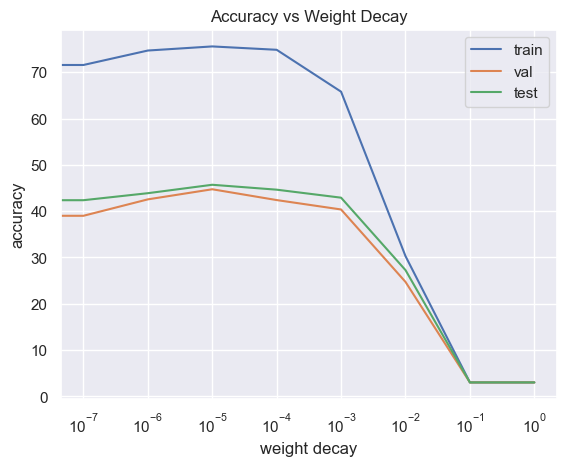

In [7]:
train_acc_list = df['train_acc'].tolist()
val_acc_list = df['val_acc'].tolist()
test_acc_list = df['test_acc'].tolist()
decay_list = df['decay'].tolist()

# plot all accuracies vs log of decay
plt.plot(decay_list, train_acc_list, label='train')
plt.plot(decay_list, val_acc_list, label='val')
plt.plot(decay_list, test_acc_list, label='test')
plt.xscale('log')
plt.xlabel('weight decay')
plt.ylabel('accuracy')
plt.title("Accuracy vs Weight Decay")
plt.legend()
plt.savefig("acc_vs_decay.png", dpi=1000)

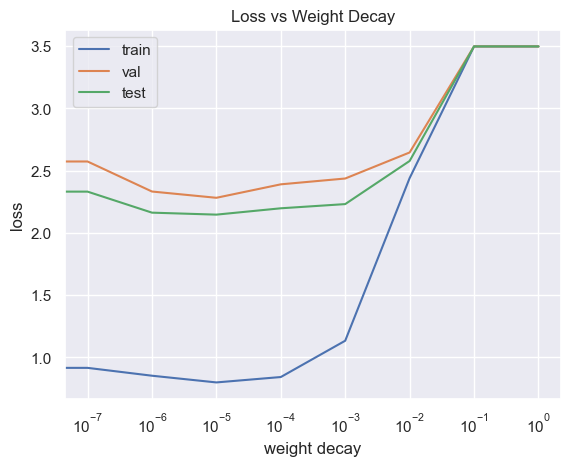

In [8]:
train_loss_list = df['train_loss'].tolist()
val_loss_list = df['val_loss'].tolist()
test_loss_list = df['test_loss'].tolist()

# plot all losses vs log of decay
plt.plot(decay_list, train_loss_list, label='train')
plt.plot(decay_list, val_loss_list, label='val')
plt.plot(decay_list, test_loss_list, label='test')
plt.xscale('log')
plt.xlabel('weight decay')
plt.ylabel('loss')
plt.title("Loss vs Weight Decay")
plt.legend()
plt.savefig("loss_vs_decay.png", dpi=1000)